## DivvyUp relies on R for web scraping and R's formidable Hadleyverse for most data cleaning and reshaping tasks. What follows below is the Python parts of DivvyUp, largely pandas and numpy for the heavy computational lifting, and matplotlib for simple plotting.

## An interactive DivvyUp can be found at https://vast-hamlet-12388.herokuapp.com/. 

### First import the necessary packages:

In [1]:
#first import the necessary packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## R's data.table package has been used to bind and append a ticker column to the scraped 2018 historical daily opening bell data of 5,943 domestic and international stocks, which includes most of the stocks traded on the Nasdaq, NYS, and American Exchanges. The data is then imported below:

In [2]:
Full2018Stocks = pd.read_csv('/home/cynthiaorourke/Documents/Data/Full2018Stocks.csv', header = 0)
#a date as a datetime variable column is created from the date as object column:
Full2018Stocks['date_as_date'] =  pd.to_datetime(Full2018Stocks['Date'], format='%Y-%m-%d')

## Daily rate of change (ROC) is how DivvyUp evaluates the similarity or diversity of two stocks. Stocks that change in the same direction and at the same percent magnitude over time are stocks that are calculated to have very low diversity relative to one another. Conversely, stocks whose value changes are not corrleated are calculated as having high diversity relative to one another. 

In [3]:
#ROC values as (Day 2 value - Day 1 Value)/(Day 1 Value) are created here:
Full2018Stocks['daily_ROC']=(Full2018Stocks['Open']-Full2018Stocks['Open'].shift(1))/Full2018Stocks['Open'].shift(1)
# print(Full2018Stocks.iloc[0:3,:]) #code to check results - unhash to use

  Name        Date       High        Low       Open      Close     Volume  \
0    A  2018-01-02  67.889999  67.339996  67.419998  67.599998  1047800.0   
1    A  2018-01-03  69.489998  67.599998  67.620003  69.320000  1698900.0   
2    A  2018-01-04  69.820000  68.779999  69.540001  68.800003  2230700.0   

  date_as_date  daily_ROC  
0   2018-01-02        NaN  
1   2018-01-03   0.002967  
2   2018-01-04   0.028394  
(1436234, 9)


In [4]:
#Here I clean the borders up so that the first entry for each stock has a ROC value of 0
#Otherwise it would reflect price change based on the last entry of the stock before it
#0 is the column with Name values, which can be used to find these problematic borders
for i in Full2018Stocks.index:
    if Full2018Stocks.iloc[i,0]!=Full2018Stocks.iloc[i-1,0]:
        Full2018Stocks.loc[Full2018Stocks.index==i,'daily_ROC'] = 0

In [7]:
#Bounded ROC is an indexed form of ROC, equal to (Day2-Day1/(Day2+Day1))/2 
Full2018Stocks['bounded_ROC']=0.5*(Full2018Stocks['Open']-Full2018Stocks['Open'].shift(1))/(Full2018Stocks['Open']+Full2018Stocks['Open'].shift(1))
# print(Full2018Stocks.iloc[0:2,:]) #code to check results - unhash to use

In [8]:
#As above, cleaning up a border artifact:
for i in Full2018Stocks.index:
    if Full2018Stocks.iloc[i,0]!=Full2018Stocks.iloc[i-1,0]:
        Full2018Stocks.loc[Full2018Stocks.index==i,'bounded_ROC'] = 0

In [9]:
#Ticker CAMP was scraped as camp - fixing here
Full2018Stocks['Name']= Full2018Stocks['Name'].replace('camp', 'CAMP')

In [10]:
#Checking the date for missing values.
#There shouldn't be any, but if there are, it is probably easiest to remove the problem stocks. 
#If there are many missing values, revisit the web scraping/data cleaning steps.
print(Full2018Stocks['daily_ROC'].isna().sum()) 
print(Full2018Stocks['bounded_ROC'].isna().sum()) 

0
0


## Now splitting it quarterly chunks, both for validation (how well do Divvy's recommendations perform in the following quarter?) and also to limit the depth of the time series, allowing for more precise quarterly rebalancing events. 

### Jan 3 - March 30 Q1 (no daily ROC on day 1 of Q1)
### Apr 2 - Jun 29 Q2
### Jul 2 - Sep 28 Q3
### Oct 1 - Dec 31 Q4

In [11]:
Q1=Full2018Stocks[(Full2018Stocks.date_as_date >= '2018-01-03')&(Full2018Stocks.date_as_date <= '2018-03-02')]
Q2=Full2018Stocks[(Full2018Stocks.date_as_date >= '2018-04-02')&(Full2018Stocks.date_as_date <= '2018-06-29')]
Q3=Full2018Stocks[(Full2018Stocks.date_as_date >= '2018-07-02')&(Full2018Stocks.date_as_date <= '2018-09-28')]
Q4=Full2018Stocks[(Full2018Stocks.date_as_date >= '2018-10-01')&(Full2018Stocks.date_as_date <= '2018-12-31')]

In [13]:
#Recommend creating some .csvs to save locally at this point
#That would keep you from having to repeat the above work every time you want to run analyes
#An alternative would be to use a pickling approach, e.g., dill
Q1.to_csv('/home/cynthiaorourke/Documents/Shiny_Coins/DivvyUp/Q1.csv', sep=',', encoding='utf-8', index=False)
Q2.to_csv('/home/cynthiaorourke/Documents/Shiny_Coins/DivvyUp/Q2.csv', sep=',', encoding='utf-8', index=False)
Q3.to_csv('/home/cynthiaorourke/Documents/Shiny_Coins/DivvyUp/Q3.csv', sep=',', encoding='utf-8', index=False)
Q4.to_csv('/home/cynthiaorourke/Documents/Shiny_Coins/DivvyUp/Q4.csv', sep=',', encoding='utf-8', index=False)

In [21]:
#Finding fourth quartil volume values, which are important for making sure that Divvy is only bringing...
#... back stocks for which it has sufficient market data to reliably judge
#First the median values for each ticker are found, and then those medians are sorted into quantiles
#Only the top quantile is used for Divvy's fetch action, reducing the pool to ~1,486 stocks (still pretty good)
Q1play=Q1.copy()
Quarts = Q1play.groupby('Name').median().quantile(0.75)
Quarts

High               44.509999
Low                43.384999
Open               43.910001
Close              43.990002
Volume         671300.000000
daily_ROC           0.000895
bounded_ROC         0.000224
Name: 0.75, dtype: float64

In [22]:
Q2play=Q2.copy()
Quarts = Q2play.groupby('Name').median().quantile(0.75)
Quarts

High               43.327501
Low                42.373751
Open               42.780000
Close              42.847501
Volume         596050.000000
daily_ROC           0.001752
bounded_ROC         0.000437
Name: 0.75, dtype: float64

In [23]:
Q3play=Q3.copy()
Quarts = Q3play.groupby('Name').median().quantile(0.75)
Quarts

High               44.235000
Low                43.242501
Open               43.727501
Close              43.717499
Volume         535425.000000
daily_ROC           0.001023
bounded_ROC         0.000256
Name: 0.75, dtype: float64

In [24]:
Q4play=Q4.copy()
Quarts = Q4play.groupby('Name').median().quantile(0.75)
Quarts

High               38.990002
Low                37.648499
Open               38.307499
Close              38.205001
Volume         657725.000000
daily_ROC           0.000000
bounded_ROC         0.000000
Name: 0.75, dtype: float64

## You're now ready to run DivvyUp on any portfolio, starting with mine as of January 2019:

In [28]:
a = 'COF'
b = 'COST'
c = 'MSFT'
d = 'DTE'
e = 'KO'
f = 'POR'
g = 'SCYX'
h = 'SURF' 
i = 'NWN'
j = 'ACC'
k = 'LADR'
l = 'GMLP'
#Note that any stock that is not in Divvy's pile of 5,943, or isn't in the quarter of interest...
#... will break the code.

Stocks = [a,b,c,d,e,f,g,i,j,k,l] #create a stock list here

#This limits the comparisons to stocks that Divvy only has full-quarter records of:
Start = min(Q1.date_as_date)
End = max(Q1.date_as_date)
Full_run_stocks=[]
for stock in Stocks:
    if (min(Q1.date_as_date[(Q1['Name']==stock)]) == Start and 
    max(Q1.date_as_date[(Q1['Name']==stock)]) == End):
        Full_run_stocks.append(stock)

#Creates a dictionary of the daily ROC values of each of these stocks:
changes={}
for stock in Full_run_stocks:
    changes[stock]=Q1.bounded_ROC[(Q1['Name']==stock)&(Q1['date_as_date']>=Start)&(Q1['date_as_date']<=End)]

#Creates a dictionary of the pairwise distances between the ROC values of each of these stocks:
distances={}    
for stock in Full_run_stocks:
    for stock2 in Full_run_stocks:
        if stock>=stock2: continue #keeps that dictionary from containing each pair twice
        diff_ = np.subtract(changes[stock],changes[stock2])
        absol_ = np.absolute(diff_)
        distances[(stock,stock2)] = np.round(10000*np.mean(absol_),decimals=2)
#*10000 above because numbers in this range - percent-like numbers - are easier for humans to visually compare

print('Start date:',Start) #Double-checking the start and end dates to make sure we have...
print('End date:',End) #A full quarter time series comparison for all included stocks

#Returns the average Diversity (Div) Score for this profile:
print('Average Div Score:',np.round(sum(distances.values())/len(distances),decimals=2))
    
key_max = max(distances.keys(), key=(lambda k: distances[k]))
key_min = min(distances.keys(), key=(lambda k: distances[k]))

#Returns your most diverse stock pair:
for keys, value in distances.items():    
    if value == distances[key_max]:
        print('Maximum Div Score:',keys, distances[key_max])
#Returns your least diverse stock pair - one of these two should be targeted for replacement:
for keys, value in distances.items():    
    if value == distances[key_min]:
        print('Mimimum Div Score:',keys, distances[key_min])

Start date: 2018-01-03 00:00:00
End date: 2018-03-02 00:00:00
Average Div Score: 37.48
Maximum Div Score: ('NWN', 'SCYX') 62.57
Mimimum Div Score: ('DTE', 'POR') 14.25


In [31]:
#You can compare the past quarter's performance of your least diverse pair here
#This is one potential criteria for picking the one to target for replacement
focal1 = 'DTE'
focal2 = 'POR'

focal1_df = Q1[(Q1['Name']==focal1)]
focal1_df.reset_index(inplace=True, drop=True)
Start = min(focal1_df.date_as_date)
End = max(focal1_df.date_as_date)
focal1_start=focal1_df.loc[focal1_df.date_as_date==Start,'Open'].values[0]
focal1_end=focal1_df.loc[focal1_df.date_as_date==End,'Open'].values[0]
type(focal1_start)
percent_focal1=100*(focal1_end-focal1_start)/(focal1_start)

focal2_df = Q1[(Q1['Name']==focal2)]
focal2_df.reset_index(inplace=True, drop=True)
Start = min(focal2_df.date_as_date)
End = max(focal2_df.date_as_date)
focal2_start=focal2_df.loc[focal2_df.date_as_date==Start,'Open'].values[0]
focal2_end=focal2_df.loc[focal2_df.date_as_date==End,'Open'].values[0]
type(focal1_start)
percent_focal2=100*(focal2_end-focal2_start)/(focal2_start)

print('Percent focal1 gain=',percent_focal1)
print('Percent focal2 gain=',percent_focal2)

Percent focal1 gain= -6.982541602468203
Percent focal2 gain= -10.755816730756736


In [30]:
#Having selected my stock to replace, it becomes the "Focal" for comparisons below:
Focal = 'DTE'
print('Which of these two are you least attached to?',Focal) #A reminder of the harsh choice you've made

#Pull only 200 stocks at random from the set of ~6,000
#Both for speed and for the element of adventure
#This isn't an optimization problem - we're not looking to find The One most diverse stock from our Focal
#We're looking to find diversity-building and novel (to the user) stocks
random_comps=np.random.choice(Q1.Name[(Q1['Name']!=Focal)],replace=False,size=200)
random_comps.tolist()
comps_w_focal=np.append(random_comps,Focal)
comps_w_focal.tolist()

#I want to lose as few stocks as possible in this step, because I will lose quite a few below
#So the comparison time frame is limited to the complete history of the least-complete stock in the draw:
start_dates={}
for stock in comps_w_focal:
    start_dates[stock] = min(Q1.date_as_date[(Q1['Name']==stock)])
Start = max(start_dates.values()) #the stock with the latest start value sets the date range

end_dates={}
for stock in comps_w_focal:
    end_dates[stock] = max(Q1.date_as_date[(Q1['Name']==stock)])
End = max(end_dates.values()) #the stock with the latest start value sets the date range

#Here some shallow learnign is imported - I'm restricting the returned stocks to those with decent volumes...
#... and end-quarter values that were at least equal to their start-quarter values (not adjusted for inflation)
good_comps_w_focal=[]
for stock in comps_w_focal:
    end_vol = Q1.Volume[(Q1['Name']==stock)&(Q1['date_as_date']==End)]
    start_vol = Q1.Volume[(Q1['Name']==stock)&(Q1['date_as_date']==Start)]
    end_vol.reset_index(inplace=True, drop=True)
    start_vol.reset_index(inplace=True, drop=True)
    end_price = Q1.Open[(Q1['Name']==stock)&(Q1['date_as_date']==End)]
    start_price = Q1.Open[(Q1['Name']==stock)&(Q1['date_as_date']==Start)]
    end_price.reset_index(inplace=True, drop=True)
    start_price.reset_index(inplace=True, drop=True)
    if stock == Focal: continue
    if (end_vol[0] >= 671300 and start_vol[0] >= 671300 and end_price[0] >= start_price[0]):
        good_comps_w_focal.append(stock)       
#Even with 200 stocks drawn, sometimes none of them make it through this selection step...
#... and an error is thrown
#Just run the code again if that happens - Divvy will fetch a fresh random sample of 200

good_comps_w_focal.append(Focal) #get the Focal back in there

changes={}
distances={}

for stock in good_comps_w_focal:
    changes[stock]=Q1.bounded_ROC[(Q1['Name']==stock)&(Q1['date_as_date']>=Start)&(Q1['date_as_date']<=End)]
        
for stock in good_comps_w_focal:
    if stock==Focal: continue 
    diff_ = np.subtract(changes[stock],changes[Focal])
    absol_ = np.absolute(diff_)
    distances[(stock,Focal)] = np.round(10000*np.mean(absol_),decimals=2)

print('Start date:',Start)
print('End date:',End)
print('Average Div Score:',np.round(sum(distances.values())/len(distances),decimals=2)) #*10 to make it impressive
distances

print('Stock Pair Div Score') 
for stock in distances.items():
    print('{} {}'.format(stock,Focal))

key_max = max(distances.keys(), key=(lambda k: distances[k]))
key_min = min(distances.keys(), key=(lambda k: distances[k]))

#This code tells you the most diverse suggested replacement:
for keys, value in distances.items():    
    if value == distances[key_max]:
        print('Maximum Div Score:',keys, distances[key_max])

Which of these two are you least attached to? DTE
Start date: 2018-01-17 00:00:00
End date: 2018-03-02 00:00:00
Average Div Score: 65.81
Stock Pair Div Score
(('APPS', 'DTE'), 75.42) DTE
(('CIG', 'DTE'), 59.35) DTE
(('MSFT', 'DTE'), 38.73) DTE
(('AVP', 'DTE'), 69.43) DTE
(('TGTX', 'DTE'), 90.95) DTE
(('AGO', 'DTE'), 45.9) DTE
(('MOS', 'DTE'), 53.07) DTE
(('XYL', 'DTE'), 30.8) DTE
(('FRC', 'DTE'), 38.69) DTE
(('RYAM', 'DTE'), 57.97) DTE
(('FOSL', 'DTE'), 153.38) DTE
(('MAT', 'DTE'), 76.08) DTE
Maximum Div Score: ('FOSL', 'DTE') 153.38


### The outcomes step below illustrates why DivvyUp is intended to be a stock recommender and NOT a stock predictor - you are supposed to be the human in this loop, going out there and looking into these suggested stocks to judge them for yourself.

### For this test case, Divvy's suggested replacements performed on mean over 19% better than the focal to be replaced, DTE, but on median slightly over 7% worse. Use your own judgement when choosing stocks! 

## Divvy is a travel guide, not a robo-investor.

In [32]:
#This is the fun part!
#Now take some of Divvy's suggestions - maybe the ones with the highest Div Scores relative to the focal
#And see how they did in the second quarter:

focal = 'DTE'
swaps = ['FOSL','APPS','TGTX','MAT','CIG'] 
#FOSL (+135%) and MAT (+24.58%) did way better than DTE (-0.62%)
#Conversely, DTE (-0.62%) did way better than APPS (-24.24%), TGTX (-7.69%), or CIG (-29.07%)

focal_df = Q2[(Q2['Name']==focal)]
focal_df.reset_index(inplace=True, drop=True)
Start = min(focal_df.date_as_date)
End = max(focal_df.date_as_date)
focal_start=focal_df.loc[focal_df.date_as_date==Start,'Open'].values[0]
focal_end=focal_df.loc[focal_df.date_as_date==End,'Open'].values[0]
type(focal_start)
percent_focal=100*(focal_end-focal_start)/(focal_start)

swap_gains=[]
for swap in swaps:
    swap_df = Q2[(Q2['Name']==swap)]
    swap_df.reset_index(inplace=True, drop=True)
    Start = min(swap_df.date_as_date)
    End = max(swap_df.date_as_date)
    swap_start=swap_df.loc[swap_df.date_as_date==Start,'Open'].values[0]
    swap_end=swap_df.loc[swap_df.date_as_date==End,'Open'].values[0]
    type(focal_start)
    percent_swap=100*(swap_end-swap_start)/(swap_start)
    print(np.round(percent_swap,decimals=2))

print('% focal gain:',np.round(percent_focal,decimals=2))

135.71
-24.24
-7.69
24.58
-29.07
% focal gain: -0.62


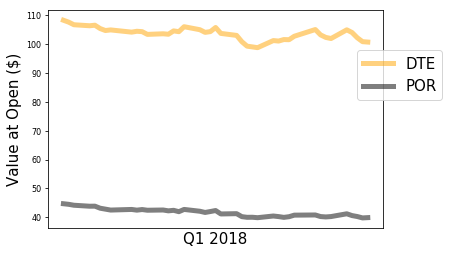

In [38]:
#One last thing - below you can plot the within-quarter outcome of any two stocks
#This is handy for visualizing next-quarter outcomes, or checking out exactly what a low diversity score...
#... looks like (I'm going to use it for that right now)
import matplotlib.pyplot as plt

width = 6
length = 4
plt.rcParams['figure.figsize'] = (width, length)
plt.rcParams.update({'font.size': 8})

a = 'DTE' #These two had a first-quarter Div Score of 14.25
b = 'POR' #So let's visualize that similarity below

y1=1*Q1['Open'][(Q1['Name'] == a)] #Replace 1 with a larger number if this stock is squished at the bottom
y2=1*Q1['Open'][(Q1['Name'] == b)] #Replace 1 with a larger number if this stock is squished at the bottom
x=Q1['date_as_date'][(Q1['Name'] == a)] #to set a shared axis

plt.plot(x, y1,c='orange',linewidth=5,alpha=0.5,label=a)
plt.plot(x, y2,c='black',linewidth=5,alpha=0.5,label=b)

plt.legend(loc=9, prop={'size': 15},bbox_to_anchor=[1.05, 0.85])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Value at Open ($)',fontsize=15)
plt.xlabel('Q1 2018',fontsize=15)
plt.show()

## Notes for using this script beyond Q1->Q2, and with varied filtering parameters:

### To find suggested replacements for Q2, Q3, or Q4, and/or to test out Q2 or Q3 suggestions against Q3 or Q4 performances (respectively), use Find and Replace under Edit above (or your favorite text editor) to switch out Q values in the appropriate cells.

### Try not to forget to change the volumes to reflect top-quartile volumes for each quarter, though honestly these are all close enough that forgetting wouldn't have too much of an impact. 

### If you want Divvy to bring back only stocks that have been performing very well, edit the start price / end price argument in line 39 to require a stock with an end-quarter value substantially higher than its start-quarter value. 

### If you want Divvy to bring back a greater diversity of stocks, edit the start price / end price argument to be more lax, for example an end-quarter value that is at least 75% as high as the start-quarter value. Be careful, though - lowering this bar too much can bring back some astonishingly low-performing stocks. 